In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'

# All, feedback weights

More than one TF file; check it is correct.
ScalarEvent(wall_time=1659846035.0292416, step=49699, value=0.003947519231587648)
ScalarEvent(wall_time=1659846062.924372, step=49, value=0.00045067782048135996)
ScalarEvent(wall_time=1659846062.9248035, step=49, value=0.0036200142931193113)


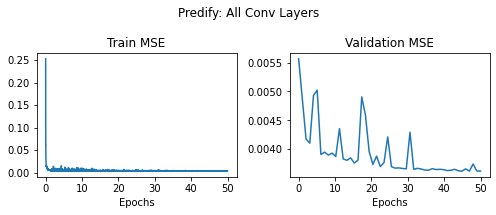

In [3]:
tfdir = tensorboard_dir + 'all/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[-2]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

print(ea.Scalars('MSE Train/Sum')[-1])
print(ea.Scalars('MSE Eval/PCoder3')[-1])
print(ea.Scalars('MSE Eval/Sum')[-1])

fig, axs = plt.subplots(1, 2, figsize = (7, 3))
train_loss = [e.value for e in ea.Scalars('MSE Train/Sum')]
eval_loss = [e.value for e in ea.Scalars('MSE Eval/Sum')]
axs[0].plot(np.linspace(0, len(eval_loss), len(train_loss)), train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Epochs')
axs[1].plot(np.linspace(0, len(eval_loss), len(eval_loss)), eval_loss)
axs[1].set_title('Validation MSE')
axs[1].set_xlabel('Epochs')
plt.suptitle('Predify: All Conv Layers')
plt.tight_layout()
plt.show()

# All, hyperparameters

More than one TF file; check it is correct.
11


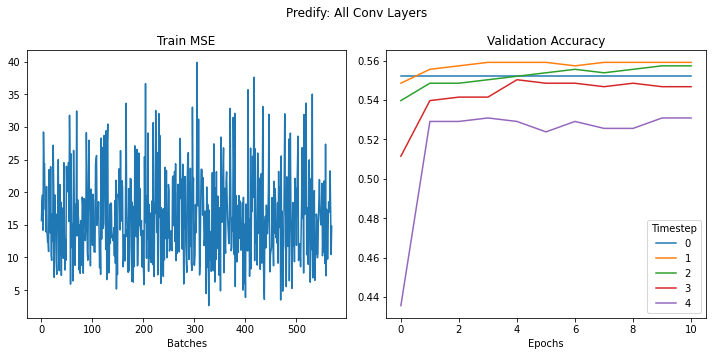

In [58]:
tfdir = tensorboard_dir + 'hyper_audscene_snr3_FFstart/'
tfdir_files = os.listdir(tfdir)
if len(tfdir_files) > 1:
    print('More than one TF file; check it is correct.')
tffile = tfdir + tfdir_files[0]
ea = event_accumulator.EventAccumulator(tffile)
ea.Reload()

train_loss = [e.value for e in ea.Scalars('TrainingLoss/CE')]
eval_loss = [[] for _ in range(5)]
epoch = 0
while True:
    try:
        for layer in range(5):
            eval_loss[layer].append(
                ea.Scalars(f'NoisyPerf/Epoch#{epoch}')[layer].value
                )
        epoch += 1
    except:
        print(epoch)
        break

fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].plot(train_loss)
axs[0].set_title('Train MSE')
axs[0].set_xlabel('Batches')
for layer in range(5):
    axs[1].plot(
        np.arange(len(eval_loss[layer])),
        eval_loss[layer], label=layer
        )
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].legend(title='Timestep')
plt.suptitle('Predify: All Conv Layers')
plt.tight_layout()
plt.show()

In [61]:
ea.Scalars(f'FeedForwardPerf/Epoch#0')

[ScalarEvent(wall_time=1660014651.8076715, step=0, value=0.552028238773346),
 ScalarEvent(wall_time=1660014651.807788, step=1, value=0.5485008955001831)]